# CA1 Deep Learning Assignment (RNN)

- Name: Jaysoorya Rajendran
- Admin Number: P2309024
- Class: DAAA/FT/2A/01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, SimpleRNN, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2

# Exploratory Data Analysis

- **(1) Problem Identified**: The dataset had a split of Malay and English, and 1 or 2 samples of Chinese and Nippon
  - **Solution**: Translated the Malay to English and removed the Chinese and Nippon
  - **Reasoning**: The dataset is relatively small, so figured that instead of training the model with both malay and english, it would make more sense to train it with a larger number of english reviews. Moreover, it would be extremely hard to do the preprocessing for Malay as it does not have the necessary libraries. The chinese and nippon were removed as they contained too little data to do anything with.

- **(2) Problem Identified**: The first 3 columns of the reviews said the exact same thing with 3 different scores
  - **Solution**: Only kept in the review  with the lowest score
  - **Reasoning**: After realising that the lower the score, the better, I decided to keep the score of 0.1 in as it fit the review very well

- **(3) Observation**: The english reviews had many of mixed lengths, ranging from 1 word to about 2 sentences
  - **Action Taken**: I realised that this could be a potential way to increase the dataset, and thus, split the sentences which were longer into more reviews while keeping their score the same
  - **Reasoning**: These extra data can really help the model train on a wider variety of data, which can help its generalisation greatly. Thus, being able to help the model have a better evaluation

In [2]:
df = pd.read_csv('Movie reviews.csv')

## Understading the Dataset

In [3]:
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.10,NaN,Malay
1,"Sayang sekali, pelakon tidak memberikan persem...",0.80,NaN,Malay
2,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,NaN,Malay
3,Pembuat filem berjaya memberikan pengalaman ya...,0.05,NaN,Malay
4,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,NaN,Malay
...,...,...,...,...
520,Pening,0.70,NaN,Malay
521,Berkesan,0.20,NaN,Malay
522,Mengujakan,0.10,NaN,Malay
523,Sederhana and teruk,0.60,NaN,Malay


# Data Wrangling

In [4]:
df = df[~df['Language'].isin(['Chinese', 'Nippon'])]

df['Language'].value_counts()

Language
English    298
Malay      224
Name: count, dtype: int64

## Conversion of the data from Malay to English

In [5]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate reviews from Malay to English
def translate_to_english(text):
    try:
        translation = translator.translate(text, src='ms', dest='en')
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

# Apply translation function to the 'Review' column where 'Language' is Malay
df.loc[df['Language'] == 'Malay', 'Review'] = df.loc[df['Language'] == 'Malay', 'Review'].apply(translate_to_english)

# Update the 'Language' column to 'English' for translated reviews
df.loc[df['Language'] == 'Malay', 'Language'] = 'English'

In [6]:
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,This movie is great!Thrilling action and shock...,0.10,NaN,English
1,"Unfortunately, the actor didn't give the best ...",0.80,NaN,English
2,Complex and emotional storyline.So entertaining!,0.20,NaN,English
3,The filmmaker succeeded in providing an unforg...,0.05,NaN,English
4,Excessive and shocking action scenes.Sometimes...,0.40,NaN,English
...,...,...,...,...
520,Dizzy,0.70,NaN,English
521,Effective,0.20,NaN,English
522,Exciting,0.10,NaN,English
523,Moderate and severe,0.60,NaN,English


In [7]:
df['Language'].value_counts()

Language
English    522
Name: count, dtype: int64

In [8]:
print('dataset shape: ',df.shape)

dataset shape:  (522, 4)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522 entries, 0 to 524
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 522 non-null    object 
 1   Score                                                                                  521 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               522 non-null    object 
dtypes: float64(2), object(2)
memory usage: 20.4+ KB


## Checking for Duplicates

-  I decided to keep the duplicates in as it still contributed to helping the model improve generalization

In [10]:
print("Duplicates in Dataset: ",df['Review'].duplicated().sum())

Duplicates in Dataset:  128


## Testing for Null values

In [11]:
missing_data = df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
Review,0,0.00
Score,1,0.19
"Are there ways for you to generate more data? Spliting up sentences, would that help?",522,100.00
Language,0,0.00


In [12]:
df = df.dropna(subset=['Score'])

In [13]:
missing_data = df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
Review,0,0.0
Score,0,0.0
"Are there ways for you to generate more data? Spliting up sentences, would that help?",521,100.0
Language,0,0.0


# Data Preprocessing

- Editing the Data so that it can be trained on properly
- All the steps taken were made after reviewing the data. For example there is no removing abbreviations as the dataset didnt have any.

## Lowercasing The Reviews

In [14]:
df['Review'] = df['Review'].str.lower()

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\614070552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].str.lower()


## Removing Punctuation

In [15]:
import string
import pandas as pd

def replace_punctuation_with_spaces(text):
    return text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

# Assuming df is your DataFrame
df['Review'] = df['Review'].apply(replace_punctuation_with_spaces)

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\1039614954.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].apply(replace_punctuation_with_spaces)


## Removing Stopwords

In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def stopwords_removal(text):
    new_text=[]
    for word in text.split():
        if word in stop_words:
            new_text.append('')
        else:
            new_text.append(word)
    x=new_text[:]
    new_text.clear()
    return " ".join(x)

df['Review'] = df['Review'].apply(stopwords_removal)

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\1564334337.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].apply(stopwords_removal)


## Removing Contractions

In [17]:
import contractions

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

df['Review'] = df['Review'].apply(expand_contractions)


C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\1037297924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].apply(expand_contractions)


## Lemmatizing the Dataset and POS Tagging

In [18]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Download WordNet and other necessary resources if not already downloaded
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match is found

# Function to perform lemmatization on a single text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Apply POS tagging
    tagged_tokens = pos_tag(tokens)
    # Lemmatize each token with its POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    # Join the lemmatized tokens back into a single string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Function to apply lemmatization to a DataFrame
def lemmatize_reviews(df):
    df['Review'] = df['Review'].apply(lemmatize_text)
    return df

df = lemmatize_reviews(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\1379155151.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Review'].apply(lemmatize_text)


# Changing the Score Values to 0 and 1 instead to to allow Sentiment Analysis

In [19]:
df['Score'] = df['Score'].apply(lambda x: 1 if x < 0.5 else 0)

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\3100551418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'] = df['Score'].apply(lambda x: 1 if x < 0.5 else 0)


# Dataset After Preprocessing

In [20]:
df.head(20)

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,movie great thrill action shocking plot,1,NaN,English
1,unfortunately actor give best performance disa...,0,NaN,English
2,complex emotional storyline entertain,1,NaN,English
3,filmmaker succeed provide unforgettable experi...,1,NaN,English
4,excessive shock action scene sometimes much,1,NaN,English
5,excite throughout movie interesting storytelling,1,NaN,English
6,avenger endgame frustrate bore many clichings,0,NaN,English
7,integration science fiction element interest like,1,NaN,English
8,movie excite deep emotional nuance,1,NaN,English
9,overall incredible cinematic experience amaze,1,NaN,English


# Data Augmentation

## Splitting up the longer sentences

- Splitting up the sentences to a max length of 4 words each, so that there will be alot more data for the model to train on

In [21]:
import pandas as pd

review_splits = []
score_splits = []

# Iterate over each review and its corresponding score
for num, sentence in enumerate(df['Review']):
    words = sentence.split()
    # Create sequences of 4 words each
    for i in range(4, len(words) + 1):
        review_splits.append(' '.join(words[i-4:i]))
        score_splits.append(df['Score'].iloc[num])

# Create a new DataFrame with the split sequences and corresponding scores
df = pd.DataFrame({'Review': review_splits, 'Score': score_splits})

# Display the first few rows of the new DataFrame
df

,Review,Score
0,movie great thrill action,1
1,great thrill action shocking,1
2,thrill action shocking plot,1
3,unfortunately actor give best,0
4,actor give best performance,0
...,...,...
2961,intricate plot unexpected twist,1
2962,underwhelming moment weak characterization,0
2963,breathtaking visuals engage narrative,1
2964,top notch effect captivate,1


## New Shape

- As observed, the model now has alot more data to be trained on

In [22]:
df.shape

(2966, 2)

# Assigning X and y

In [23]:
X = df['Review']
y = df['Score']

# Split the Data

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

# Tokenization

- Tokenization breaks text into smaller units called tokens, like words or phrases. This process helps the model understand and process text for various tasks.
- For example, "This movie was absolute garbage" becomes ["This", "movie", "was", "absolute", "garbage"].

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print('Number of unique words: ',len(tokenizer.word_index))
print(tokenizer.document_count)

Number of unique words:  625
1660


In [26]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

# Padding 

- Padding data involves adding extra elements to sequences to make them all the same length. It ensures that input data fits a uniform shape required by models. 
- For example, if you have sequences of different lengths like [1, 2, 3] and [4, 5], padding them to a length of 4 might result in [1, 2, 3, 0] and [4, 5, 0, 0]. Which is why, the X_train[0] data is as such

In [27]:
max_length = 0
for sequence in X_train:
    # Calculate the length of the sequences
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length

print("Maximum sequence length:", max_length)

Maximum sequence length: 4


In [28]:
X_train=pad_sequences(X_train,maxlen=5)
X_val=pad_sequences(X_val,maxlen=5)
X_test=pad_sequences(X_test,maxlen=5)

In [29]:
X_train[0] # Padding makes the data look like this for each review

array([  0,  11,  64, 205, 234])

In [30]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [31]:
# Define early stopping callback
Early_Stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss ( Since I'm using classification )
    patience = 16,           # Stop training after 16 epochs with no improvement
    restore_best_weights=True  # Restore the weights that give the best validation loss
)

# Simple RNN Model (Baseline Model)

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

input_dim = len(tokenizer.word_index) + 1
output_dim = 50  # Reduced embedding dimension for a simpler model
input_length = 5 

baseline_RNN_model = Sequential()
baseline_RNN_model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
baseline_RNN_model.add(SimpleRNN(50)) 
baseline_RNN_model.add(Dense(1, activation='sigmoid'))

# Compile the model with an optimizer and loss function
baseline_RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
baseline_RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 50)             31300     
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 36,401
Trainable params: 36,401
Non-trainable params: 0
_________________________________________________________________


# Baseline Performance

In [33]:
# Compiling the model
baseline_RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = baseline_RNN_model.fit(X_train, y_train, epochs = 30, batch_size=64, validation_data=(X_val, y_val), callbacks = [Early_Stopping], verbose=1)

# Evaluate the best model on the test set
test_loss, test_accuracy = baseline_RNN_model.evaluate(X_test, y_test)
print("Test Loss: %.4f, Test Accuracy: %.2f%%" % (test_loss, test_accuracy * 100))

Epoch 1/30
26/26 [==============================] - 6s 55ms/step - loss: 0.5181 - accuracy: 0.8108 - val_loss: 0.4800 - val_accuracy: 0.8146
Epoch 2/30
26/26 [==============================] - 0s 13ms/step - loss: 0.3794 - accuracy: 0.8398 - val_loss: 0.3905 - val_accuracy: 0.8160
Epoch 3/30
26/26 [==============================] - 0s 16ms/step - loss: 0.2329 - accuracy: 0.9036 - val_loss: 0.2500 - val_accuracy: 0.9045
Epoch 4/30
26/26 [==============================] - 0s 16ms/step - loss: 0.1237 - accuracy: 0.9566 - val_loss: 0.1743 - val_accuracy: 0.9326
Epoch 5/30
26/26 [==============================] - 0s 16ms/step - loss: 0.0764 - accuracy: 0.9801 - val_loss: 0.1538 - val_accuracy: 0.9438
Epoch 6/30
26/26 [==============================] - 1s 33ms/step - loss: 0.0552 - accuracy: 0.9837 - val_loss: 0.1447 - val_accuracy: 0.9522
Epoch 7/30
26/26 [==============================] - 2s 63ms/step - loss: 0.0463 - accuracy: 0.9855 - val_loss: 0.1484 - val_accuracy: 0.9466
Epoch 8/30
26

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\641026147.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


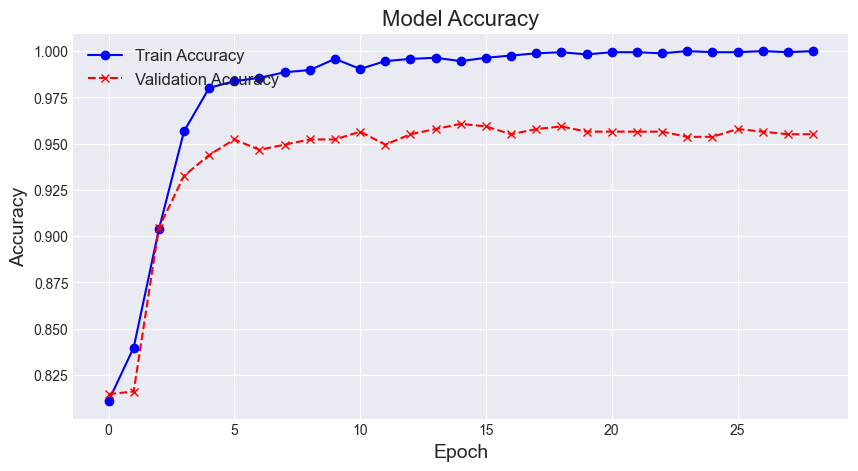

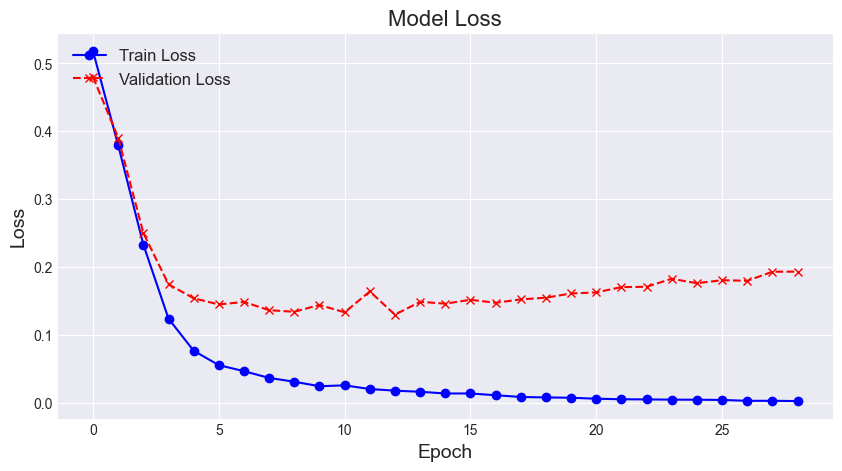

In [34]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', color='r', label='Validation Accuracy')

# Title and labels
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Define plot size
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(history.history['val_loss'], marker='x', linestyle='--', color='r', label='Validation Loss')

# Title and labels
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# BiDirectional RNN Model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, SimpleRNN, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer

input_dim = len(tokenizer.word_index) + 1
output_dim = 128  # Increased embedding dimension
input_length = 5

RNN_model = Sequential()

# Embedding layer with increased output dimension
RNN_model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
RNN_model.add(SpatialDropout1D(0.3))  # Increased dropout for more regularization

# First Bidirectional RNN layer with increased units
RNN_model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
RNN_model.add(Dropout(0.3))
RNN_model.add(BatchNormalization())

# Second Bidirectional RNN layer with increased units
RNN_model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
RNN_model.add(Dropout(0.3))
RNN_model.add(BatchNormalization())

# Final SimpleRNN layer without return sequences
RNN_model.add(SimpleRNN(32, return_sequences=False))

# Dense layers with increased units and regularization
RNN_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
RNN_model.add(Dropout(0.3))  # Added dropout layer to prevent overfitting
RNN_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
RNN_model.add(Dropout(0.3))  # Another dropout layer for regularization
RNN_model.add(Dense(1, activation='sigmoid'))

# Compile the model with an optimizer and loss function
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 128)            80128     
                                                                 
 spatial_dropout1d (SpatialD  (None, 5, 128)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 5, 256)           65792     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 batch_normalization (BatchN  (None, 5, 256)           1024      
 ormalization)                                                   
                                                      

# BiDirectional Performance

In [36]:
# Compiling the model
RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = RNN_model.fit(X_train, y_train, epochs = 30, batch_size=64, validation_data=(X_val, y_val), callbacks = [Early_Stopping], verbose=1)

# Evaluate the best model on the test set
test_loss, test_accuracy = RNN_model.evaluate(X_test, y_test)
print("Test Loss: %.4f, Test Accuracy: %.2f%%" % (test_loss, test_accuracy * 100))

Epoch 1/30
26/26 [==============================] - 7s 86ms/step - loss: 1.6556 - accuracy: 0.8386 - val_loss: 1.5380 - val_accuracy: 0.8146
Epoch 2/30
26/26 [==============================] - 2s 95ms/step - loss: 1.2837 - accuracy: 0.8392 - val_loss: 1.1464 - val_accuracy: 0.8146
Epoch 3/30
26/26 [==============================] - 2s 87ms/step - loss: 0.9281 - accuracy: 0.8717 - val_loss: 0.8780 - val_accuracy: 0.8862
Epoch 4/30
26/26 [==============================] - 2s 58ms/step - loss: 0.6589 - accuracy: 0.9488 - val_loss: 0.6488 - val_accuracy: 0.9396
Epoch 5/30
26/26 [==============================] - 3s 121ms/step - loss: 0.4702 - accuracy: 0.9699 - val_loss: 0.4356 - val_accuracy: 0.9649
Epoch 6/30
26/26 [==============================] - 1s 55ms/step - loss: 0.3484 - accuracy: 0.9789 - val_loss: 0.3533 - val_accuracy: 0.9593
Epoch 7/30
26/26 [==============================] - 2s 70ms/step - loss: 0.2631 - accuracy: 0.9813 - val_loss: 0.3282 - val_accuracy: 0.9354
Epoch 8/30
2

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\641026147.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


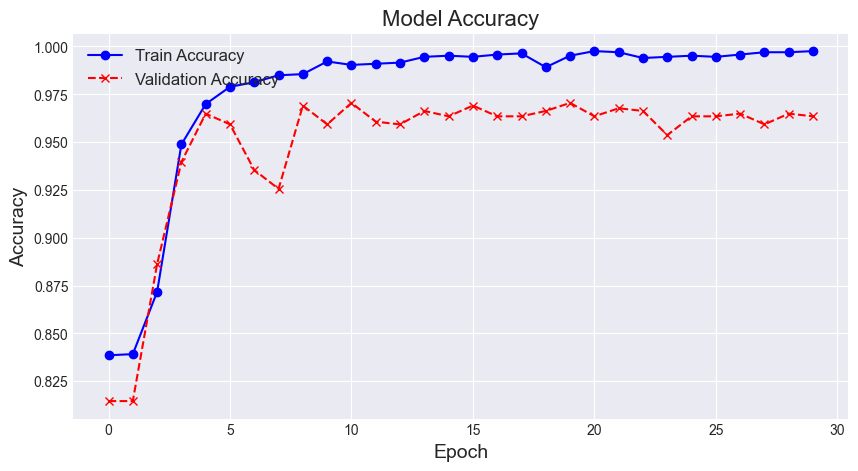

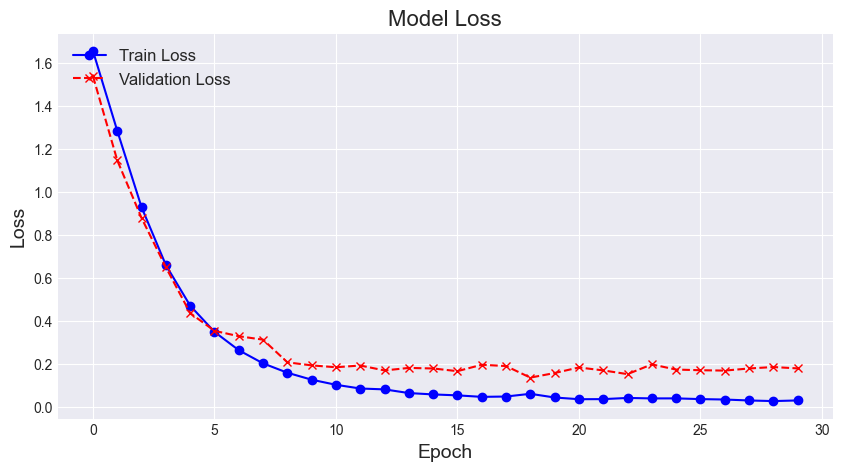

In [37]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', color='r', label='Validation Accuracy')

# Title and labels
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Define plot size
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(history.history['val_loss'], marker='x', linestyle='--', color='r', label='Validation Loss')

# Title and labels
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# LSTM Model

In [38]:
# Define the improved LSTM model
lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=5))

# Spatial Dropout
lstm_model.add(SpatialDropout1D(0.3))

# First Bidirectional LSTM layer
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))

# Second Bidirectional LSTM layer
lstm_model.add(Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))

# Batch Normalization
lstm_model.add(BatchNormalization())

# Dense layer with ReLU activation
lstm_model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
lstm_model.add(Dropout(0.4))

# Output layer with sigmoid activation
lstm_model.add(Dense(1, activation='sigmoid'))

# Summarize the model
lstm_model.summary()

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5, 128)            80128     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 5, 128)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 128)           98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                      

# LSTM Performance

In [39]:
history = lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val), callbacks=[Early_Stopping], verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/20
26/26 [==============================] - 20s 359ms/step - loss: 1.1488 - accuracy: 0.7205 - val_loss: 1.0809 - val_accuracy: 0.8146
Epoch 2/20
26/26 [==============================] - 6s 244ms/step - loss: 0.7813 - accuracy: 0.8916 - val_loss: 0.8720 - val_accuracy: 0.8146
Epoch 3/20
26/26 [==============================] - 8s 280ms/step - loss: 0.4999 - accuracy: 0.9464 - val_loss: 0.7166 - val_accuracy: 0.8146
Epoch 4/20
26/26 [==============================] - 6s 249ms/step - loss: 0.3596 - accuracy: 0.9596 - val_loss: 0.6077 - val_accuracy: 0.8385
Epoch 5/20
26/26 [==============================] - 8s 324ms/step - loss: 0.2652 - accuracy: 0.9789 - val_loss: 0.5139 - val_accuracy: 0.8694
Epoch 6/20
26/26 [==============================] - 6s 215ms/step - loss: 0.2060 - accuracy: 0.9819 - val_loss: 0.4357 - val_accuracy: 0.9087
Epoch 7/20
26/26 [==============================] - 7s 285ms/step - loss: 0.1567 - accuracy: 0.9861 - val_loss: 0.3608 - val_accuracy: 0.9522
Epoch

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\641026147.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


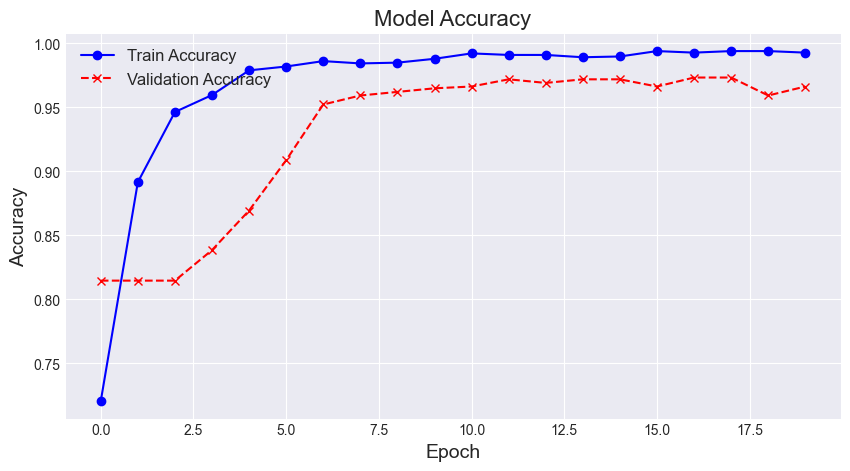

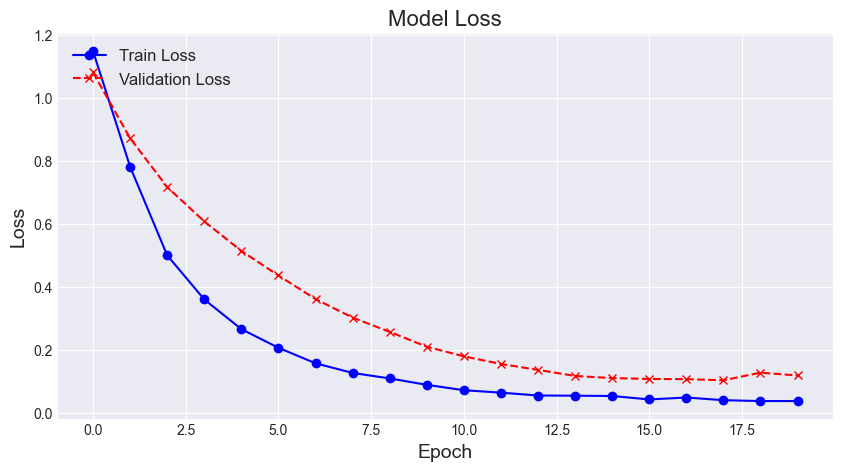

In [40]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', color='r', label='Validation Accuracy')

# Title and labels
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Define plot size
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(history.history['val_loss'], marker='x', linestyle='--', color='r', label='Validation Loss')

# Title and labels
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# GRU Model

In [41]:
# Define the improved GRU model
GRU_model = Sequential()

# Embedding layer
GRU_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=5))

# Spatial Dropout
GRU_model.add(SpatialDropout1D(0.3))

# First GRU layer
GRU_model.add(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

# Second GRU layer
GRU_model.add(GRU(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

# Batch Normalization
GRU_model.add(BatchNormalization())

# Dense layer with ReLU activation
GRU_model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
GRU_model.add(Dropout(0.4))

# Output layer with sigmoid activation
GRU_model.add(Dense(1, activation='sigmoid'))

# Summarize the model
GRU_model.summary()

# Compile the model
GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5, 128)            80128     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 5, 128)           0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 5, 64)             37248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)               

# GRU Performance

In [42]:
history = GRU_model.fit(X_train, y_train, epochs = 30, batch_size=64, validation_data=(X_val, y_val), callbacks=[Early_Stopping], verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = GRU_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/30
26/26 [==============================] - 9s 148ms/step - loss: 0.9921 - accuracy: 0.6705 - val_loss: 0.9757 - val_accuracy: 0.8146
Epoch 2/30
26/26 [==============================] - 3s 115ms/step - loss: 0.7288 - accuracy: 0.8566 - val_loss: 0.8614 - val_accuracy: 0.8146
Epoch 3/30
26/26 [==============================] - 3s 103ms/step - loss: 0.5347 - accuracy: 0.9102 - val_loss: 0.7452 - val_accuracy: 0.8146
Epoch 4/30
26/26 [==============================] - 4s 139ms/step - loss: 0.3882 - accuracy: 0.9512 - val_loss: 0.6407 - val_accuracy: 0.8146
Epoch 5/30
26/26 [==============================] - 4s 148ms/step - loss: 0.3143 - accuracy: 0.9620 - val_loss: 0.5497 - val_accuracy: 0.8371
Epoch 6/30
26/26 [==============================] - 3s 131ms/step - loss: 0.2487 - accuracy: 0.9777 - val_loss: 0.4743 - val_accuracy: 0.8680
Epoch 7/30
26/26 [==============================] - 3s 133ms/step - loss: 0.2105 - accuracy: 0.9771 - val_loss: 0.4154 - val_accuracy: 0.8750
Epoch 

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\641026147.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


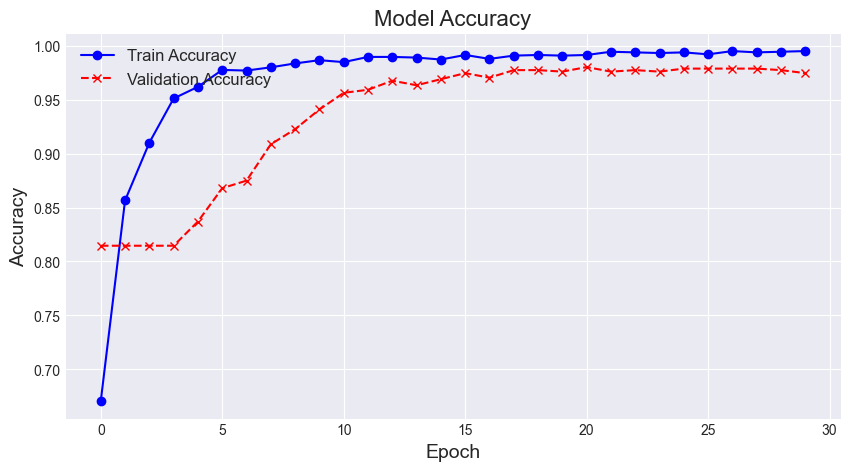

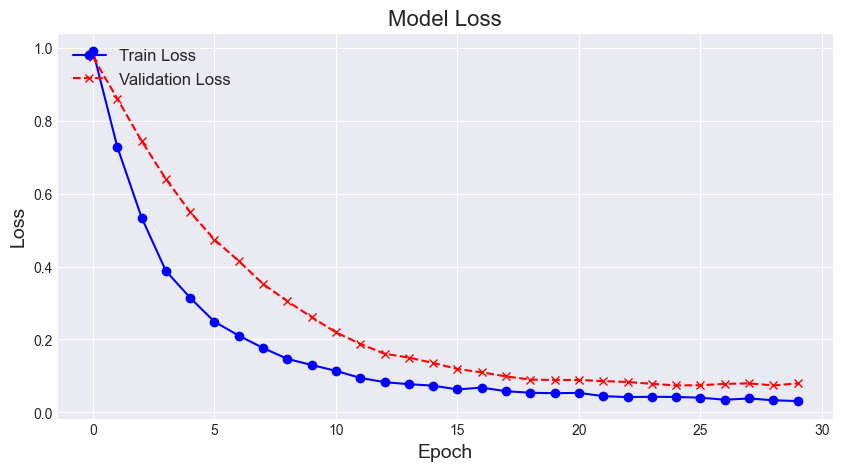

In [43]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', color='r', label='Validation Accuracy')

# Title and labels
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Define plot size
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(history.history['val_loss'], marker='x', linestyle='--', color='r', label='Validation Loss')

# Title and labels
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Grid and legend
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Hyperparameter Tuning Best Model ( GRU Model )

- For the Hyperparameter Tuning, I decided to test some stuff, such as the Units, Number of layers, Dropout rates for each layers and finally, the learning rates

- **(1) Units in GRU layers (units):**
  - **Range: 32 to 256**: 
  - **Step: 32**: 
  - **Description**: Description: The number of units (neurons) in each GRU layer. This determines the dimensionality of the output space.

- **(2) Number of GRU layers (num_layers)l:**
  - **Range: 1 to 5**
  - **Description**: The number of GRU layers to include in the model. This controls the depth of the neural network.

- **(3) Dropout rates for each GRU layer (dropout_rate):**
  - **Range: 0.1 to 0.5**: 
  - **Step: 0.1**:
  - **Desciption**: The fraction of the input units to drop (set to zero) during training for regularization. This helps prevent overfitting by randomly setting a fraction of input units to zero at each update during training

- **(4) Learning rate for the Adam optimizer (learning_rate):**
  - **Values: [0.01, 0.001, 0.0001]**: 
  - **Desciption**: The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated. It is a crucial hyperparameter that affects how quickly the model converges to a solution.
  

In [44]:
import keras
from keras.layers import Embedding, SpatialDropout1D, GRU, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

# Assume maxlen is defined somewhere in your code
maxlen = 5

def Hyper_GRU_model(hp):
    model = Sequential()
    
    input_dim = len(tokenizer.word_index) + 1
    
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen))
    
    # Add SpatialDropout layer (fixed as in GRU_model)
    model.add(SpatialDropout1D(0.3))
    
    # Dynamic range for number of units
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    
    # Dynamic range for number of layers based on the number of units
    num_layers = hp.Int('num_layers', min_value=1, max_value=5)
    
    for i in range(num_layers):
        model.add(GRU(units, return_sequences=True, dropout=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1), recurrent_dropout=0.3, name=f'gru_layer_{i}'))
    
    model.add(GRU(units, dropout=hp.Float('final_dropout_rate', min_value=0.1, max_value=0.5, step=0.1), recurrent_dropout=0.3, name='final_gru_layer'))
    
    # Add BatchNormalization layer (fixed as in GRU_model)
    model.add(BatchNormalization())
    
    # Add Dense layer with ReLU activation and L2 regularization (fixed as in GRU_model)
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    print("Model built with the following architecture:")
    model.summary()
    
    return model

In [45]:
import keras_tuner as kt
tuner = kt.RandomSearch(Hyper_GRU_model,objective = 'val_accuracy',
                       max_trials = 5,
                       directory = 'GRU_hyperparameter',
                       project_name='GRU_hyperparameter')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))           

Reloading Tuner from GRU_hyperparameter\GRU_hyperparameter\tuner0.json


## Getting best Parameters

In [46]:
# Retrieve the best trial
best_trial = tuner.oracle.get_best_trials(1)[0]

# Get the best hyperparameters from the trial
best_hyperparameters = best_trial.hyperparameters

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.get_config())

Best Hyperparameters:
{'space': [{'class_name': 'Int', 'config': {'name': 'units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'num_layers', 'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout_rate_0', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'final_dropout_rate', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}, {'class_name': 'Float', 'config': {'name': 'dropout_rate_1', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}

## Obtaining the best model

In [47]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Model built with the following architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 128)            80128     
                                                                 
 spatial_dropout1d (SpatialD  (None, 5, 128)           0         
 ropout1D)                                                       
                                                                 
 gru_layer_0 (GRU)           (None, 5, 160)            139200    
                                                                 
 gru_layer_1 (GRU)           (None, 5, 160)            154560    
                                                                 
 final_gru_layer (GRU)       (None, 160)               154560    
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalizati

# Final Evaluation of Models

## Simple RNN ( Baseline Model )

In [48]:
from sklearn.metrics import accuracy_score

baseline_RNN_model = baseline_RNN_model.predict(X_test)
baseline_RNN_model = (baseline_RNN_model > 0.5).astype('int')
baseline_RNN_model_acc = accuracy_score(baseline_RNN_model,y_test)*100

print("baseline_RNN_model Score is :",baseline_RNN_model_acc,'%')

19/19 [==============================] - 0s 7ms/step
baseline_RNN_model Score is : 96.12794612794613 %


In [49]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, baseline_RNN_model, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.896226,0.887850,0.892019,107.000000
1,0.975410,0.977413,0.976410,487.000000
accuracy,0.961279,0.961279,0.961279,0.961279
macro avg,0.935818,0.932632,0.934215,594.000000
weighted avg,0.961146,0.961279,0.961208,594.000000


In [50]:
sentiment_labels = {0: 'negative', 1: 'positive'}

baseline_RNN_mode = [[sentiment_labels[val[0]]] for val in baseline_RNN_model]
baseline_RNN_mode[0:10]

[['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['negative'],
 ['positive'],
 ['positive'],
 ['negative']]

## Bi-Directional RNN

In [51]:
from sklearn.metrics import accuracy_score

RNN_pred = RNN_model.predict(X_test)
RNN_pred = (RNN_pred > 0.5).astype('int')
Bidirection_RNN_Accuracy = accuracy_score(RNN_pred,y_test)*100

print("Bidirection_RNN_Accuracy Score is :",Bidirection_RNN_Accuracy,'%')

19/19 [==============================] - 2s 28ms/step
Bidirection_RNN_Accuracy Score is : 96.29629629629629 %


In [52]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, RNN_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.869565,0.934579,0.900901,107.000000
1,0.985386,0.969199,0.977226,487.000000
accuracy,0.962963,0.962963,0.962963,0.962963
macro avg,0.927476,0.951889,0.939063,594.000000
weighted avg,0.964523,0.962963,0.963477,594.000000


In [53]:
sentiment_labels = {0: 'negative', 1: 'positive'}

RNN_sentiments = [[sentiment_labels[val[0]]] for val in RNN_pred]
RNN_sentiments[0:10]

[['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['negative'],
 ['positive'],
 ['positive'],
 ['negative']]

# LSTM Model

In [54]:
lstm_pred = lstm_model.predict(X_test)
lstm_pred = (lstm_pred > 0.5).astype('int')

LSTM_Accuracy = accuracy_score(lstm_pred,y_test)*100
print("LSTM_Accuracy Score is :",LSTM_Accuracy,'%')

19/19 [==============================] - 1s 36ms/step
LSTM_Accuracy Score is : 97.47474747474747 %


In [55]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, lstm_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.933962,0.925234,0.929577,107.000000
1,0.983607,0.985626,0.984615,487.000000
accuracy,0.974747,0.974747,0.974747,0.974747
macro avg,0.958784,0.955430,0.957096,594.000000
weighted avg,0.974664,0.974747,0.974701,594.000000


In [56]:
sentiment_labels = {0: 'negative', 1: 'positive'}

lstm_sentiments = [[sentiment_labels[val[0]]] for val in lstm_pred]
lstm_sentiments[0:10]

[['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['negative'],
 ['positive'],
 ['positive'],
 ['negative']]

# Hypertuned GRU (Grated Recurrent Unit)

In [57]:
Hypertuned_GRU_pred = best_model.predict(X_test)
Hypertuned_GRU_pred = (Hypertuned_GRU_pred > 0.5).astype('int')

Hypertuned_GRU_Accuracy = accuracy_score(Hypertuned_GRU_pred,y_test)*100
print("Hypertuned_GRU_Accuracy Score is :",Hypertuned_GRU_Accuracy,'%')

19/19 [==============================] - 2s 30ms/step
Hypertuned_GRU_Accuracy Score is : 98.82154882154882 %


In [58]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, Hypertuned_GRU_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.990196,0.943925,0.966507,107.000000
1,0.987805,0.997947,0.992850,487.000000
accuracy,0.988215,0.988215,0.988215,0.988215
macro avg,0.989000,0.970936,0.979679,594.000000
weighted avg,0.988236,0.988215,0.988105,594.000000


In [59]:
HYpertuned_GRU_sentiments = [[sentiment_labels[val[0]]] for val in Hypertuned_GRU_pred]
HYpertuned_GRU_sentiments[0:10]

[['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['positive'],
 ['negative'],
 ['positive'],
 ['positive'],
 ['negative']]

In [60]:
comp_df = pd.DataFrame(columns = ['Bidirectional_RNN','LSTM_Sentiment','hypertune_gru_sentiments'])
comp_df['Bidirectional_RNN'] = RNN_sentiments
comp_df['LSTM_Sentiment'] = lstm_sentiments
comp_df['hypertune_gru_sentiments'] = HYpertuned_GRU_sentiments

In [61]:
comp_df.head(10)

,Bidirectional_RNN,LSTM_Sentiment,hypertune_gru_sentiments
0,[positive],[positive],[positive]
1,[positive],[positive],[positive]
2,[positive],[positive],[positive]
3,[positive],[positive],[positive]
4,[positive],[positive],[positive]
5,[positive],[positive],[positive]
6,[negative],[negative],[negative]
7,[positive],[positive],[positive]
8,[positive],[positive],[positive]
9,[negative],[negative],[negative]


# Comparing the Different Models

- Using this, we can see which model performed the best. 

In [62]:
# Create a DataFrame with these accuracy scores
data = {
    'Model': ['Bidirectional RNN', 'LSTM', 'Hypertuned GRU'],
    'Accuracy': [Bidirection_RNN_Accuracy, LSTM_Accuracy, Hypertuned_GRU_Accuracy]
}
Acc_df = pd.DataFrame(data)

C:\Users\Jay\AppData\Local\Temp\ipykernel_14732\2053993173.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=Acc_df, palette='viridis', ax=ax)


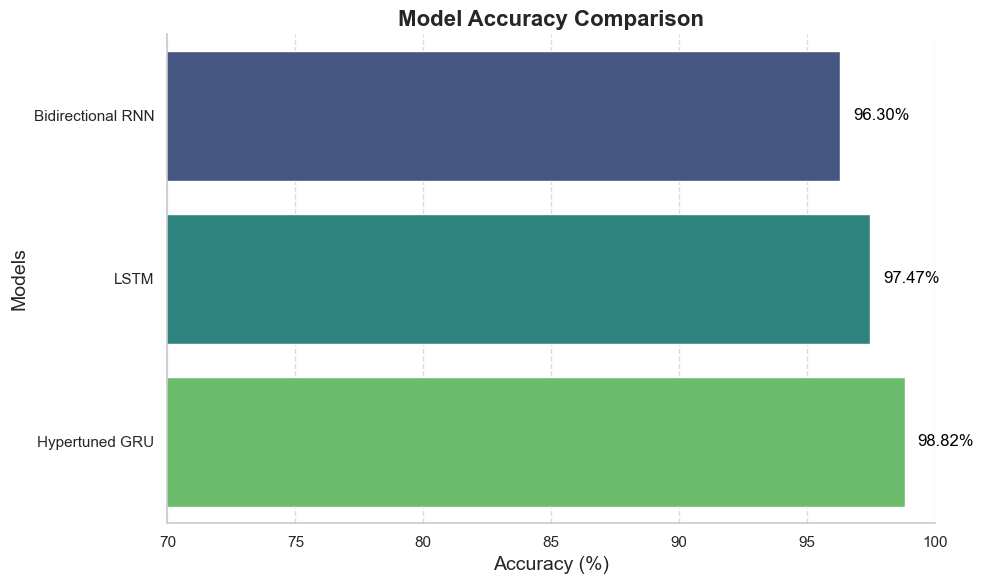

In [63]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a plot figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the DataFrame as a horizontal bar plot
sns.barplot(x='Accuracy', y='Model', data=Acc_df, palette='viridis', ax=ax)

# Add labels, title, and customize the plot
ax.set_xlabel('Accuracy (%)', fontsize=14)
ax.set_ylabel('Models', fontsize=14)
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Set the x-axis limit
ax.set_xlim(70, 100)

# Add data labels
for i, accuracy in enumerate(Acc_df['Accuracy']):
    ax.text(accuracy + 0.5, i, f'{accuracy:.2f}%', va='center', fontsize=12, color='black')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

# Model Deployment

In [64]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Example test movie reviews ( Taken from different MOvies in IMDB)
test_reviews = [
    "This movie is an absolute masterpiece! The director's vision truly shines through, leaving me speechless.",
    "I found this film to be incredibly boring. The plot was weak and the pacing was slow. Would not recommend.",
    "The performances in this movie were absolutely outstanding. Each actor brought their character to life in the most mesmerizing way.",
    "The special effects in this film were absolutely mind-blowing. I was completely mesmerized and left in awe the entire time.",
    "I simply couldn't engage with this movie at all. It completely failed to capture even a hint of my interest.",
    "This movie was an emotional rollercoaster! I laughed, I cried, and I couldn't tear my eyes away.",
    "I was on the edge of my seat the entire time! The suspense was palpable, and the twist ending was unexpected.",
    "This movie was a total snoozefest. I struggled to stay awake and ended up regretting even trying.",
    "This movie was really great. I enjoyed every moment of it. The acting was superb and the plot was engaging."
]

# Preprocess the test reviews the same way the training data was preprocessed
preprocessed_test_reviews = [preprocess_text(review) for review in test_reviews]

X_test_deployment = tokenizer.texts_to_sequences(preprocessed_test_reviews)
X_test_deployment = pad_sequences(X_test_deployment, maxlen=5)  # Assuming max_sequence_length is defined

# Make predictions using your trained model
predictions = best_model.predict(X_test_deployment)

# Convert predictions to sentiment labels (positive or negative)
sentiment_labels = ["Positive" if pred >= 0.5 else "Negative" for pred in predictions]

# Print the test reviews along with their predicted sentiment
for review, sentiment in zip(test_reviews, sentiment_labels):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print()

1/1 [==============================] - 0s 29ms/step
Review: This movie is an absolute masterpiece! The director's vision truly shines through, leaving me speechless.
Predicted Sentiment: Positive

Review: I found this film to be incredibly boring. The plot was weak and the pacing was slow. Would not recommend.
Predicted Sentiment: Negative

Review: The performances in this movie were absolutely outstanding. Each actor brought their character to life in the most mesmerizing way.
Predicted Sentiment: Positive

Review: The special effects in this film were absolutely mind-blowing. I was completely mesmerized and left in awe the entire time.
Predicted Sentiment: Positive

Review: I simply couldn't engage with this movie at all. It completely failed to capture even a hint of my interest.
Predicted Sentiment: Negative

Review: This movie was an emotional rollercoaster! I laughed, I cried, and I couldn't tear my eyes away.
Predicted Sentiment: Positive

Review: I was on the edge of my seat th

#  **Final Model Analysis**

**The sentiment analysis model demonstrates robust performance in classifying movie reviews into positive and negative sentiments. Despite encountering some subjective nuances in the reviews, the model maintains a commendable accuracy in predicting the sentiment of each review.**

**Positive Sentiments:**

- The model accurately identifies reviews expressing positive sentiments, capturing aspects such as praise for outstanding performances, captivating special effects, emotional engagement, and thrilling suspense.

**Negative Sentiments:**

- Similarly, the model effectively discerns reviews conveying negative sentiments, detecting criticisms regarding boredom, weak plots, slow pacing, and lack of engagement.


**Overall Performance:**

The sentiment analysis model exhibits a reliable ability to differentiate between positive and negative sentiments, providing valuable insights into the emotional response of viewers towards the movies.